In [1]:
!pip install keras
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install sklearn

In [2]:
# Import libraries and modules
import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Resizing
from keras.layers import BatchNormalization
from keras.metrics import CosineSimilarity
from keras.metrics import BinaryAccuracy
from sklearn.metrics.pairwise import euclidean_distances
from tensorflow.keras import layers
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
def normalize_pixels(image):
    """normalize pixels to be between 0 and 1"""

	# convert from integers to floats
    image_norm = image.astype('float32')
	# normalize to range -1 and 1
    image_norm = (image_norm - 127.5) / 127.5

	# return normalized images
    return image_norm

def de_normalize_pixels(image, _from = 0, _to = 1):
    """de-normalize pixels to be between 0 and 255"""

    # Normalize between 0 and 1
    image_de_norm = (image * 127.5) + 127.5

    # Normalize between 0 and 1
    image_de_norm = image_de_norm/255 

    # Normalize between _from and _to
    image_de_norm = (image_de_norm * (_to - _from)) + _from
    
    return image_de_norm

def load_image(path):
    """load image from path and convert to array"""

    img = load_img(path, target_size=(224, 224), interpolation='bilinear')
    x = img_to_array(img)
    x = normalize_pixels(x)
    x = np.expand_dims(x, axis=0)
    return x

def unison_shuffled_copies(a, b):
    """shuffle two arrays in unison"""

    np.random.seed(42)

    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def pairwise_euclidean_distance(vects):
    x, y = vects
    return K.square(x - y)

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [4]:
DATA_PATH = './data/dataset'
DATA_TRAIN_SPLIT = 0.8
DATA_VALIDATION_SPLIT = 0.1

In [5]:
# Load images into arrays
import pathlib

data_dir = pathlib.Path(DATA_PATH)

image_count = len(list(data_dir.glob('*/*.jpg')) + list(data_dir.glob('*/*.jpeg')) + list(data_dir.glob('*/*.png')))
print("Total amount of images: " + str(image_count))

folders = [x for x in data_dir.iterdir() if x.is_dir()]

img_array_data = []

for i, folder in enumerate(folders):
    img_array_data.append([])

    for j, img in enumerate(folder.iterdir()):
        img_array_data[i].append(load_image(img))

Total amount of images: 555


In [6]:
data = []
labels = []

# Create image pairs
def create_image_pairs(images):
    for i, array in enumerate(images):
        for j in range(len(array)):
            # True
            data.append([
                images[i][j], 
                images[i][np.random.randint(0, len(images[i]) - 1)]])
            labels.append(1)

            x_1 = np.random.randint(0, len(images) - 1)
            x_2 = np.random.randint(0, len(images[x_1]) - 1)

            # False
            data.append([
                images[i][j], 
                images[x_1][x_2]])
            labels.append(0)

create_image_pairs(img_array_data)

data = np.array(data)
labels = np.array(labels)

In [7]:
# Shuffle Dataset
data, labels = unison_shuffled_copies(data, labels)

show_amount = 10
print(data[:show_amount])
print(labels[:show_amount])

[[[[[[-0.70980394 -0.41960785 -0.01176471]
     [-0.7254902  -0.4117647  -0.01176471]
     [-0.7254902  -0.4117647  -0.01176471]
     ...
     [-0.7176471  -0.5137255  -0.09019608]
     [-0.7647059  -0.7411765  -0.6392157 ]
     [-0.81960785 -0.8117647  -0.84313726]]

    [[-0.7254902  -0.4117647  -0.01176471]
     [-0.7254902  -0.40392157 -0.01176471]
     [-0.7254902  -0.40392157 -0.00392157]
     ...
     [-0.7254902  -0.46666667 -0.03529412]
     [-0.7254902  -0.6862745  -0.52156866]
     [-0.8117647  -0.78039217 -0.7882353 ]]

    [[-0.7254902  -0.4117647  -0.00392157]
     [-0.7254902  -0.4117647  -0.00392157]
     [-0.7254902  -0.4117647  -0.00392157]
     ...
     [-0.7254902  -0.43529412  0.01960784]
     [-0.7176471  -0.6392157  -0.39607844]
     [-0.8039216  -0.7647059  -0.75686276]]

    ...

    [[-0.6392157  -0.6627451  -0.6784314 ]
     [-0.7254902  -0.75686276 -0.8039216 ]
     [-0.6        -0.654902   -0.7019608 ]
     ...
     [-0.24705882 -0.29411766 -0.34117648]
   

In [8]:
# Split data into train, validation, and test

train_split = int(DATA_TRAIN_SPLIT * len(data))
validation_split = train_split+int(DATA_VALIDATION_SPLIT * len(data))

print("TRAIN SPLIT: " + "0 - " + str(train_split) + " | " + str(train_split) + " | " + str(DATA_TRAIN_SPLIT*100) + '%')
print("VALIDATION SPLIT: " + str(train_split) + " - " + str(validation_split) + " | " + str(validation_split-train_split) + " | " + str(DATA_VALIDATION_SPLIT*100) + '%')
print("TEST SPLIT: " + str(validation_split) + " - " + str(len(data)) + " | " + str(len(data) - validation_split) + " | " + str(100 - DATA_TRAIN_SPLIT*100 - DATA_VALIDATION_SPLIT*100) + '%')

data_train = data[0:train_split]
data_validation = data[train_split:validation_split]
data_test = data[validation_split:]

labels_train = labels[0:train_split]
labels_validation = labels[train_split:validation_split]
labels_test = labels[validation_split:]

print("---")
print("Training Data Shape: " + str(data_train.shape))
print("Validation Data Shape: " + str(data_validation.shape))
print("Test Data Shape: " + str(data_test.shape))
print("---")
print("Training Labels Shape: " + str(labels_train.shape))
print("Validation Labels Shape: " + str(labels_validation.shape))
print("Test Labels Shape: " + str(labels_test.shape))

TRAIN SPLIT: 0 - 888 | 888 | 80.0%
VALIDATION SPLIT: 888 - 999 | 111 | 10.0%
TEST SPLIT: 999 - 1110 | 111 | 10.0%
---
Training Data Shape: (888, 2, 1, 224, 224, 3)
Validation Data Shape: (111, 2, 1, 224, 224, 3)
Test Data Shape: (111, 2, 1, 224, 224, 3)
---
Training Labels Shape: (888,)
Validation Labels Shape: (111,)
Test Labels Shape: (111,)


In [43]:
def euclidean_distance_x(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

input_shape = (224, 224, 3)

# embedding extractor
# embedding_extractor = Sequential(name='embedding_extractor')

base_model = MobileNetV2(input_shape=(input_shape), include_top = True, weights='imagenet')
base_model.trainable = False
x = base_model #.layers[-1].output

# input = layers.Input((input_shape))
# x = tf.keras.layers.BatchNormalization()(input)
# x = layers.Conv2D(64, (5, 5), activation="relu")(x)
# x = layers.AveragePooling2D(pool_size=(2, 2))(x)
# x = layers.Conv2D(32, (5, 5), activation="relu")(x)
# x = layers.AveragePooling2D(pool_size=(2, 2))(x)
# x = layers.Flatten()(x)

x = BatchNormalization()(x)
prediction = Dense(10, activation='sigmoid', dtype='float32')(x)
# embedding_extractor.add(base_model)

embedding_extractor = Model(inputs=input, outputs=prediction, name='embedding_extractor')

# embedding_extractor.add(base_model)
# embedding_extractor.add(GlobalAveragePooling2D())
# embedding_extractor.add(Flatten())

embedding_extractor.summary()

# Input pair
input_image_1 = Input(input_shape)
input_image_2 = Input(input_shape)

# Output pair
encoded_image_1 = embedding_extractor(input_image_1)
encoded_image_2 = embedding_extractor(input_image_2)

merge_layer = Lambda(euclidean_distance_x)([encoded_image_1, encoded_image_2])
normal_layer = BatchNormalization()(merge_layer)
output_layer = Dense(1, activation='sigmoid', dtype='float32')(normal_layer)
siamese = Model(inputs=[input_image_1, input_image_2], outputs=output_layer, name='siamese')

# # Model
# feature_extraction_model = Model(inputs=[input_image_1, input_image_2], outputs=[encoded_image_1, encoded_image_2], name='feature_extractor')
# feature_extraction_model.summary()

def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

siamese.compile(loss=loss(margin=1), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

ValueError: Input has undefined rank. Received: input_shape=<unknown>.

In [40]:
tf.config.run_functions_eagerly(True)
history = siamese.fit(
    [data_train[:, 0, 0], data_train[:, 1, 0]],
    labels_train.astype(float),
    validation_data=([data_validation[:, 0, 0], data_validation[:, 1, 0]], labels_validation),
    batch_size=32,
    epochs=20,
)

Epoch 1/20
28/28 [==============================] - 76s 3s/step - loss: 0.3194 - accuracy: 0.4899 - val_loss: 0.3272 - val_accuracy: 0.5405
Epoch 2/20
28/28 [==============================] - 75s 3s/step - loss: 0.2871 - accuracy: 0.5214 - val_loss: 0.3113 - val_accuracy: 0.5045
Epoch 3/20
28/28 [==============================] - 75s 3s/step - loss: 0.2759 - accuracy: 0.5394 - val_loss: 0.3335 - val_accuracy: 0.4595
Epoch 4/20
28/28 [==============================] - 75s 3s/step - loss: 0.2660 - accuracy: 0.5574 - val_loss: 0.3269 - val_accuracy: 0.5315
Epoch 5/20
28/28 [==============================] - 74s 3s/step - loss: 0.2542 - accuracy: 0.5957 - val_loss: 0.3237 - val_accuracy: 0.4685
Epoch 6/20
28/28 [==============================] - 75s 3s/step - loss: 0.2363 - accuracy: 0.6306 - val_loss: 0.3554 - val_accuracy: 0.5495
Epoch 7/20
28/28 [==============================] - 75s 3s/step - loss: 0.2185 - accuracy: 0.6824 - val_loss: 0.3559 - val_accuracy: 0.4414
Epoch 8/20
28/28 [==

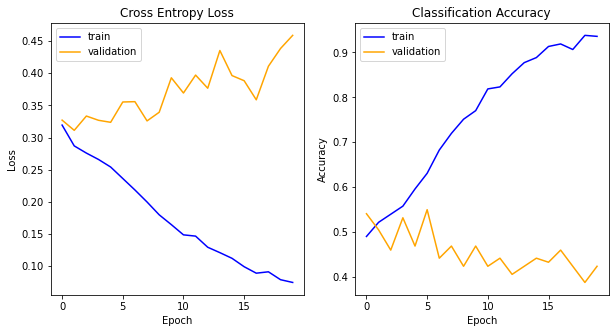

In [41]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].set_title('Cross Entropy Loss')
	ax[0].set_xlabel('Epoch')
	ax[0].set_ylabel('Loss')
	ax[0].plot(history.history['loss'], color='blue', label='train')
	ax[0].plot(history.history['val_loss'], color='orange', label='validation')
	ax[0].legend()

	# plot accuracy
	ax[1].set_title('Classification Accuracy')
	ax[1].set_xlabel('Epoch')
	ax[1].set_ylabel('Accuracy')
	ax[1].plot(history.history['accuracy'], color='blue', label='train')
	ax[1].plot(history.history['val_accuracy'], color='orange', label='validation')
	ax[1].legend()
	
	plt.show()

summarize_diagnostics(history)

In [42]:
score = siamese.evaluate(
    [data_test[:, 0, 0], data_test[:, 1, 0]], 
    labels_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4339057207107544
Test accuracy: 0.46846845746040344
